# Bitcoin Market Predictor

Predicting BTCUSD market with a recurrent neural network

# Currency Market Predictor - Deep Regressor

Predicting BTCUSD market

In [2]:
import tensorflow as tf
from tensorflow.contrib import rnn
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pickle

dataset = pickle.load( open( "dataset.p", "rb" ) )


## Read data

In [2]:
dataset = pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv')
dataset.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0
5,1417412280,300.0,300.0,300.0,300.0,0.01,3.0,300.0
6,1417412340,300.0,300.0,300.0,300.0,0.01,3.0,300.0
7,1417412400,300.0,300.0,300.0,300.0,0.01,3.0,300.0
8,1417412460,300.0,300.0,300.0,300.0,0.01,3.0,300.0
9,1417412520,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [3]:
dataset.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
1459066,1508457060,5705.25,5705.25,5705.24,5705.25,2.645729,15094.527857,5705.243162
1459067,1508457120,5705.01,5705.01,5705.01,5705.01,2.239995,12779.191992,5705.010000
1459068,1508457180,5705.01,5705.01,5701.01,5701.01,1.906660,10877.267534,5704.881021
1459069,1508457240,5703.22,5703.22,5700.00,5700.00,4.793786,27325.020313,5700.091678
1459070,1508457300,5700.01,5700.01,5700.00,5700.00,1.492222,8505.677349,5700.009268
1459071,1508457360,5700.01,5700.01,5700.00,5700.01,4.107598,23413.350886,5700.009878
1459072,1508457420,5700.01,5700.54,5700.01,5700.54,3.377075,19250.702466,5700.407366
1459073,1508457480,5700.54,5704.01,5700.53,5704.01,5.572255,31770.431877,5701.539951
1459074,1508457540,5703.96,5704.01,5702.87,5704.01,2.489754,14200.042922,5703.392752
1459075,1508457600,5704.00,5704.01,5704.00,5704.01,1.700455,9699.411610,5704.009412


In [5]:
# Make the neural net happy with the inputs: zero mean, -1 to 1
# only about 0.1% of high jumps in volume are clipped.

dataset['Weighted_Price_PCT'] = dataset['Weighted_Price'].pct_change().fillna(0)
dataset['Weighted_Price_PCT'] = dataset['Weighted_Price_PCT']*50
dataset['Weighted_Price_PCT'] = dataset['Weighted_Price_PCT'].clip(-1,1)

dataset['Weighted_Price_rolling_5'] = dataset['Weighted_Price_PCT'].rolling(5, win_type='blackmanharris').mean()
dataset['Weighted_Price_rolling_15'] = dataset['Weighted_Price_PCT'].rolling(15, win_type='blackmanharris').mean()
dataset['Weighted_Price_rolling_60'] = dataset['Weighted_Price_PCT'].rolling(60, win_type='blackmanharris').mean()*2
dataset['Weighted_Price_rolling_180'] = dataset['Weighted_Price_PCT'].rolling(180, win_type='blackmanharris').mean()*3
dataset['Weighted_Price_rolling_720'] = dataset['Weighted_Price_PCT'].rolling(720, win_type='blackmanharris').mean()*6
dataset['Weighted_Price_rolling_2880'] = dataset['Weighted_Price_PCT'].rolling(2880, win_type='blackmanharris').mean()*12
dataset['Weighted_Price_rolling_10080'] = dataset['Weighted_Price_PCT'].rolling(10080, win_type='blackmanharris').mean()*200

(-1, 1)

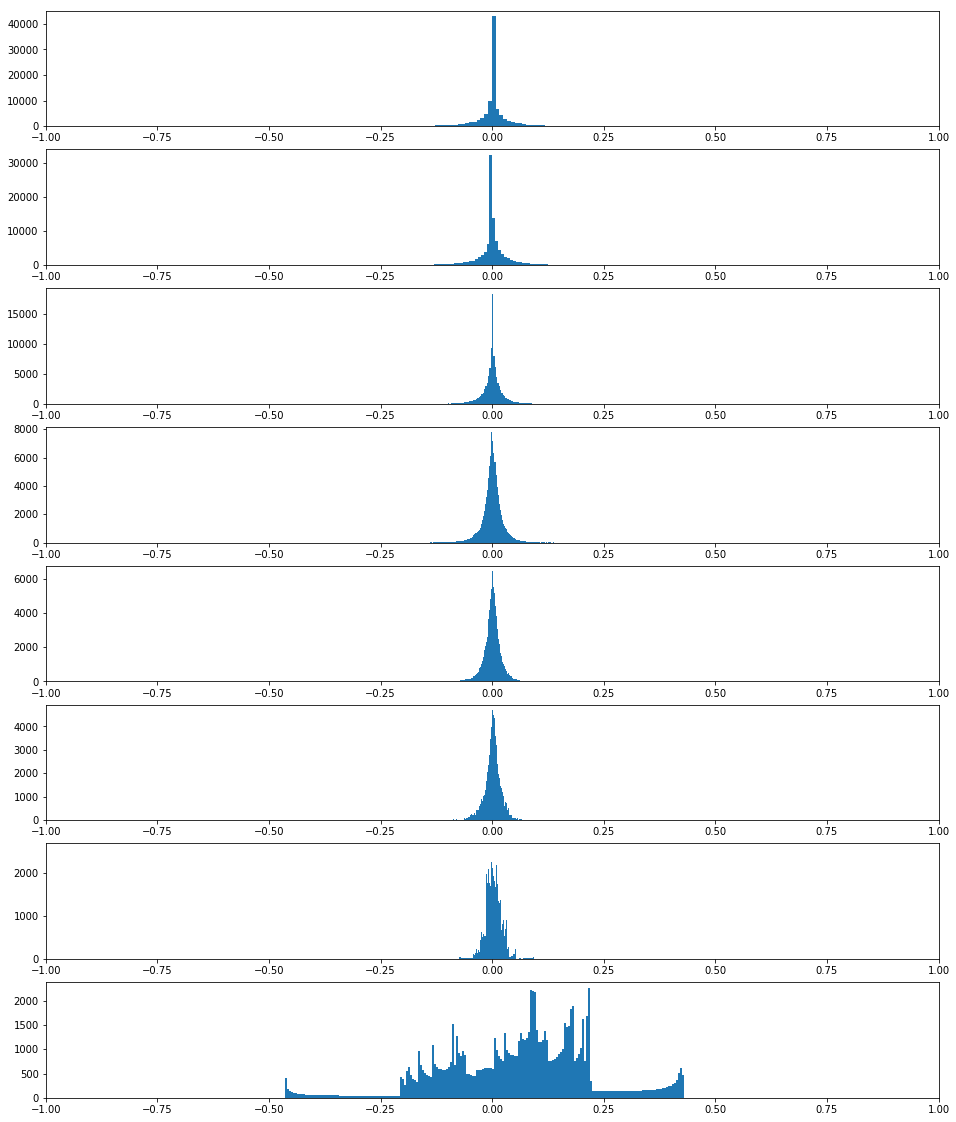

In [6]:
plt.figure(figsize=(16,20))
plt.subplot(8,1,1)
n, bins, patches = plt.hist(dataset['Weighted_Price_PCT'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,2)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_5'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,3)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_15'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,4)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_60'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,5)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_180'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,6)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_720'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,7)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_2880'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,8)
n, bins, patches = plt.hist(dataset['Weighted_Price_rolling_10080'].iloc[-100000:], 200)
plt.xlim(-1, 1)

In [7]:
dataset['Volume_PCT'] = dataset['Volume_(BTC)'].pct_change(periods=10).fillna(0)
dataset['Volume_PCT'] = dataset['Volume_PCT'] + 1
dataset['Volume_PCT'] = np.clip(np.log(dataset['Volume_PCT'])/30, -1,1)
        
dataset['Volume_PCT_rolling_5'] = dataset['Volume_PCT'].rolling(5, win_type='blackmanharris').mean()*1.5
dataset['Volume_PCT_rolling_15'] = dataset['Volume_PCT'].rolling(15, win_type='blackmanharris').mean()*2.5
dataset['Volume_PCT_rolling_60'] = dataset['Volume_PCT'].rolling(60, win_type='blackmanharris').mean()*6
dataset['Volume_PCT_rolling_180'] = dataset['Volume_PCT'].rolling(180, win_type='blackmanharris').mean()*20
dataset['Volume_PCT_rolling_720'] = dataset['Volume_PCT'].rolling(720, win_type='blackmanharris').mean()*60
dataset['Volume_PCT_rolling_2880'] = dataset['Volume_PCT'].rolling(2880, win_type='blackmanharris').mean()*250
dataset['Volume_PCT_rolling_10080'] = dataset['Volume_PCT'].rolling(10080, win_type='blackmanharris').mean()*3000

(-1, 1)

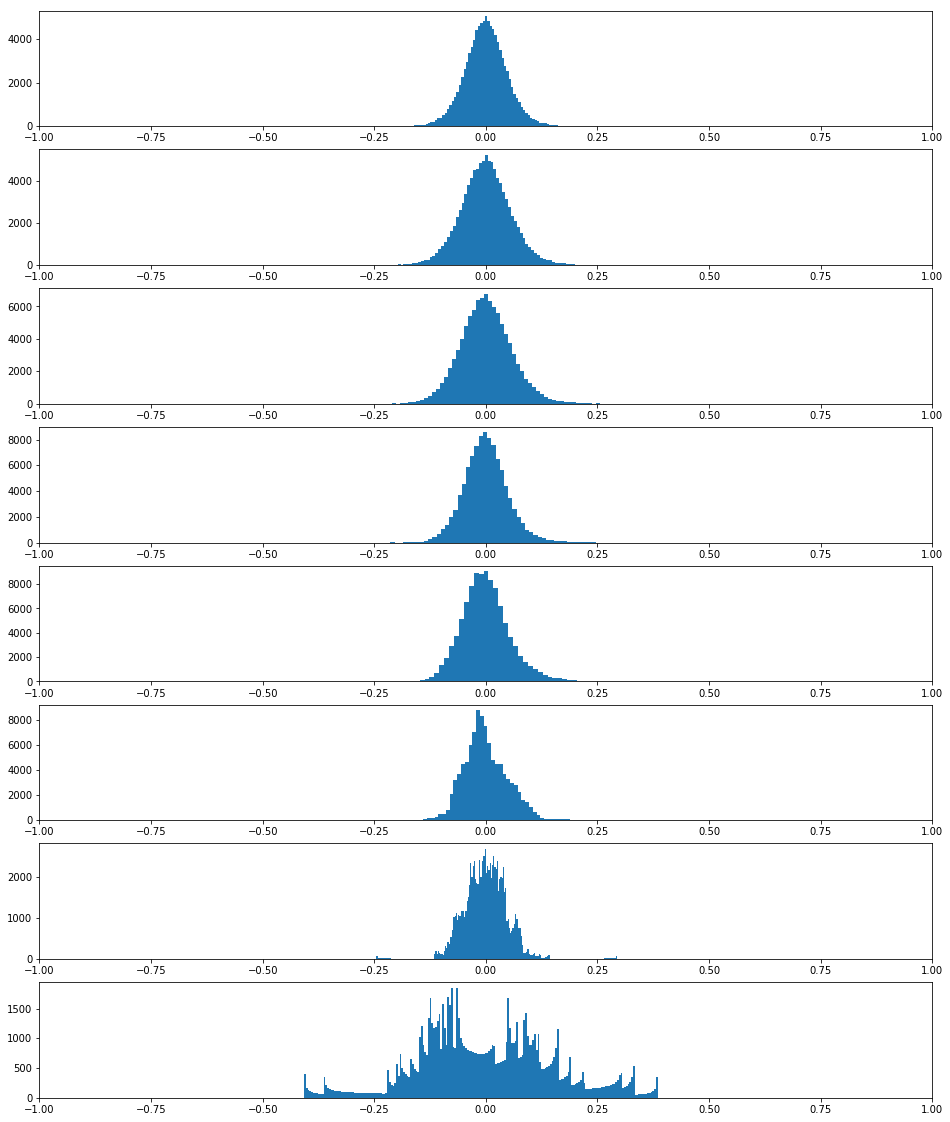

In [8]:
plt.figure(figsize=(16,20))
plt.subplot(8,1,1)
n, bins, patches = plt.hist(dataset['Volume_PCT'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,2)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_5'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,3)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_15'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,4)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_60'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,5)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_180'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,6)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_720'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,7)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_2880'].iloc[-100000:], 200)
plt.xlim(-1, 1)
plt.subplot(8,1,8)
n, bins, patches = plt.hist(dataset['Volume_PCT_rolling_10080'].iloc[-100000:], 200)
plt.xlim(-1, 1)


In [9]:
dataset.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_PCT,Weighted_Price_rolling_5,...,Weighted_Price_rolling_2880,Weighted_Price_rolling_10080,Volume_PCT,Volume_PCT_rolling_5,Volume_PCT_rolling_15,Volume_PCT_rolling_60,Volume_PCT_rolling_180,Volume_PCT_rolling_720,Volume_PCT_rolling_2880,Volume_PCT_rolling_10080
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1417412280,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,1417412340,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1417412400,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8,1417412460,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9,1417412520,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
dataset.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_PCT,Weighted_Price_rolling_5,...,Weighted_Price_rolling_2880,Weighted_Price_rolling_10080,Volume_PCT,Volume_PCT_rolling_5,Volume_PCT_rolling_15,Volume_PCT_rolling_60,Volume_PCT_rolling_180,Volume_PCT_rolling_720,Volume_PCT_rolling_2880,Volume_PCT_rolling_10080
1459066,1508457060,5705.25,5705.25,5705.24,5705.25,2.645729,15094.527857,5705.243162,-0.000059,-0.001699,...,0.030830,-0.034837,0.014936,0.025586,0.015882,-0.008729,-0.032974,-0.012127,-0.092926,0.011854
1459067,1508457120,5705.01,5705.01,5705.01,5705.01,2.239995,12779.191992,5705.010000,-0.002043,-0.000121,...,0.030817,-0.034873,0.013946,0.023168,0.042002,-0.002338,-0.033452,-0.011823,-0.092978,0.011935
1459068,1508457180,5705.01,5705.01,5701.01,5701.01,1.906660,10877.267534,5704.881021,-0.001130,-0.000343,...,0.030805,-0.034909,0.010797,0.022138,0.056592,0.002833,-0.033878,-0.011519,-0.093028,0.012015
1459069,1508457240,5703.22,5703.22,5700.00,5700.00,4.793786,27325.020313,5700.091678,-0.041976,-0.001606,...,0.030792,-0.034946,0.031525,0.020429,0.058783,0.006595,-0.034248,-0.011215,-0.093077,0.012093
1459070,1508457300,5700.01,5700.01,5700.00,5700.00,1.492222,8505.677349,5700.009268,-0.000723,-0.007458,...,0.030779,-0.034982,-0.029717,0.021620,0.053472,0.008845,-0.034567,-0.010911,-0.093127,0.012171
1459071,1508457360,5700.01,5700.01,5700.00,5700.01,4.107598,23413.350886,5700.009878,0.000005,-0.029531,...,0.030766,-0.035019,0.011198,0.028652,0.046614,0.009556,-0.034833,-0.010606,-0.093176,0.012250
1459072,1508457420,5700.01,5700.54,5700.01,5700.54,3.377075,19250.702466,5700.407366,0.003487,-0.006864,...,0.030753,-0.035055,0.028495,-0.021348,0.041313,0.008788,-0.035047,-0.010301,-0.093223,0.012328
1459073,1508457480,5700.54,5704.01,5700.53,5704.01,5.572255,31770.431877,5701.539951,0.009934,0.000421,...,0.030740,-0.035091,-0.005057,0.011428,0.037411,0.006677,-0.035214,-0.009996,-0.093270,0.012405
1459074,1508457540,5703.96,5704.01,5702.87,5704.01,2.489754,14200.042922,5703.392752,0.016248,0.003937,...,0.030726,-0.035128,-0.032186,0.031176,0.033412,0.003426,-0.035335,-0.009692,-0.093317,0.012479
1459075,1508457600,5704.00,5704.01,5704.00,5704.01,1.700455,9699.411610,5704.009412,0.005406,0.009913,...,0.030712,-0.035165,-0.013529,-0.006125,0.028418,-0.000703,-0.035413,-0.009387,-0.093362,0.012554


In [3]:
import pickle

pickle.dump( dataset, open( "dataset.p", "wb" ) )

In [4]:
list(dataset)

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume_(BTC)',
 'Volume_(Currency)',
 'Weighted_Price',
 'Weighted_Price_PCT',
 'Weighted_Price_rolling_5',
 'Weighted_Price_rolling_15',
 'Weighted_Price_rolling_60',
 'Weighted_Price_rolling_180',
 'Weighted_Price_rolling_720',
 'Weighted_Price_rolling_2880',
 'Weighted_Price_rolling_10080',
 'Volume_PCT',
 'Volume_PCT_rolling_5',
 'Volume_PCT_rolling_15',
 'Volume_PCT_rolling_60',
 'Volume_PCT_rolling_180',
 'Volume_PCT_rolling_720',
 'Volume_PCT_rolling_2880',
 'Volume_PCT_rolling_10080']

In [5]:
OFFSET = 60

SAMPLES = 1400000

input_data = dataset[['Weighted_Price_rolling_5', 'Weighted_Price_rolling_15', 'Weighted_Price_rolling_60', 
                      'Weighted_Price_rolling_180', 'Weighted_Price_rolling_720', 'Weighted_Price_rolling_2880',
                     'Weighted_Price_rolling_10080', 'Volume_PCT_rolling_5', 'Volume_PCT_rolling_15',
                     'Volume_PCT_rolling_60', 'Volume_PCT_rolling_180', 'Volume_PCT_rolling_720', 
                     'Volume_PCT_rolling_2880', 'Volume_PCT_rolling_10080']].iloc[-SAMPLES:-OFFSET] # about 2 years of data
target_data = dataset['Weighted_Price_rolling_60'].iloc[-(SAMPLES-OFFSET):]

# split data into test and validation data
prediction_mins = 36000 # 10 days

training_input = input_data[:len(input_data)-prediction_mins]
training_input = np.expand_dims(training_input, axis=1)

training_target = target_data[:len(target_data)-prediction_mins]


validation_input = input_data[-prediction_mins:]
validation_input = np.expand_dims(validation_input, axis=1)

validation_target = target_data[-prediction_mins:]

In [6]:
# Importing the Keras libraries and packages
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dropout, Dense, GRUCell
from keras.callbacks import ModelCheckpoint, EarlyStopping

from numpy.testing import assert_allclose

Using TensorFlow backend.


In [7]:
# load the model
regressor = load_model("regressor.h5")


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(GRU(2048, return_sequences=True, input_shape = (None, 14)))

# Adding the input layer and the LSTM layer
regressor.add(GRU(units = 512, input_shape = (None, 256)))

# Adding the output layer
regressor.add(Dense(64, activation='tanh'))

# Adding the output layer
regressor.add(Dense(16, activation='tanh'))

# Adding the output layer
regressor.add(Dense(1, activation='linear'))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# define the checkpoint
filepath = "regressor.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


In [15]:

# Fitting the RNN to the Training set
regressor.fit(training_input, training_target, batch_size = 512, epochs = 400, validation_split=0.2, callbacks=[checkpoint])

Train on 1091152 samples, validate on 272788 samples
Epoch 1/400
1091152/1091152 [==============================] - 63s 58us/step - loss: 2.2132e-04 - val_loss: 6.3777e-04
Epoch 2/400
1091152/1091152 [==============================] - 57s 52us/step - loss: 2.1831e-04 - val_loss: 6.3320e-04
Epoch 3/400
1091152/1091152 [==============================] - 57s 53us/step - loss: 2.1810e-04 - val_loss: 6.3308e-04
Epoch 4/400
1091152/1091152 [==============================] - 57s 52us/step - loss: 2.1779e-04 - val_loss: 6.3455e-04
Epoch 5/400
1091152/1091152 [==============================] - 57s 52us/step - loss: 2.1761e-04 - val_loss: 6.3210e-04
Epoch 6/400
1091152/1091152 [==============================] - 57s 52us/step - loss: 2.1749e-04 - val_loss: 6.3250e-04
Epoch 7/400
1091152/1091152 [==============================] - 57s 52us/step - loss: 2.1732e-04 - val_loss: 6.3367e-04
Epoch 8/400
1091152/1091152 [==============================] - 57s 53us/step - loss: 2.1710e-04 - val_loss: 6.3164

1091152/1091152 [==============================] - 56s 51us/step - loss: 1.4720e-04 - val_loss: 8.8320e-04
Epoch 60/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.4602e-04 - val_loss: 9.0901e-04
Epoch 61/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.4514e-04 - val_loss: 9.4158e-04
Epoch 62/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.4422e-04 - val_loss: 8.8612e-04
Epoch 63/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.4350e-04 - val_loss: 8.7634e-04
Epoch 64/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.4270e-04 - val_loss: 8.8681e-04
Epoch 65/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.4137e-04 - val_loss: 9.2016e-04
Epoch 66/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.4050e-04 - val_loss: 9.0031e-04
Epoch 67/400
1091152/1091152 [=======================

1091152/1091152 [==============================] - 56s 52us/step - loss: 1.2358e-04 - val_loss: 9.7501e-04
Epoch 89/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.2259e-04 - val_loss: 9.5517e-04
Epoch 90/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.2197e-04 - val_loss: 0.0010
Epoch 91/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.2124e-04 - val_loss: 9.6571e-04
Epoch 92/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.2011e-04 - val_loss: 9.7219e-04
Epoch 93/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.1990e-04 - val_loss: 9.5882e-04
Epoch 94/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.1870e-04 - val_loss: 9.6535e-04
Epoch 95/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 1.1831e-04 - val_loss: 9.5910e-04
Epoch 96/400
1091152/1091152 [===========================

Epoch 148/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 9.0221e-05 - val_loss: 0.0011
Epoch 149/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 8.9486e-05 - val_loss: 0.0011
Epoch 150/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 8.9192e-05 - val_loss: 0.0011
Epoch 151/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 8.8747e-05 - val_loss: 0.0010
Epoch 152/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 8.8294e-05 - val_loss: 0.0011
Epoch 153/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 8.7886e-05 - val_loss: 0.0011
Epoch 154/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 8.7501e-05 - val_loss: 0.0011
Epoch 155/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 8.6985e-05 - val_loss: 0.0011
Epoch 156/400
1091152/1091152 [==============================] -

Epoch 178/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 7.7988e-05 - val_loss: 0.0011
Epoch 179/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 7.7690e-05 - val_loss: 0.0011
Epoch 180/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 7.7384e-05 - val_loss: 0.0011
Epoch 181/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 7.6875e-05 - val_loss: 0.0011
Epoch 182/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 7.6424e-05 - val_loss: 0.0011
Epoch 183/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 7.6068e-05 - val_loss: 0.0011
Epoch 184/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 7.5511e-05 - val_loss: 0.0011
Epoch 185/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 7.5334e-05 - val_loss: 0.0011
Epoch 186/400
1091152/1091152 [==============================] -

Epoch 208/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 6.6909e-05 - val_loss: 0.0011
Epoch 209/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 6.6575e-05 - val_loss: 0.0011
Epoch 210/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 6.6390e-05 - val_loss: 0.0012
Epoch 211/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 6.5845e-05 - val_loss: 0.0012
Epoch 212/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 6.5531e-05 - val_loss: 0.0011
Epoch 213/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 6.5014e-05 - val_loss: 0.0012
Epoch 214/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 6.5060e-05 - val_loss: 0.0012
Epoch 215/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 6.4688e-05 - val_loss: 0.0012
Epoch 216/400
1091152/1091152 [==============================] -

Epoch 269/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 4.5596e-05 - val_loss: 0.0012
Epoch 270/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 4.5911e-05 - val_loss: 0.0012
Epoch 271/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 4.5519e-05 - val_loss: 0.0012
Epoch 272/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 4.5369e-05 - val_loss: 0.0012
Epoch 273/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 4.5103e-05 - val_loss: 0.0012
Epoch 274/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 4.4451e-05 - val_loss: 0.0012
Epoch 275/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 4.4644e-05 - val_loss: 0.0012
Epoch 276/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 4.4006e-05 - val_loss: 0.0013
Epoch 277/400
1091152/1091152 [==============================] -

1091152/1091152 [==============================] - 56s 51us/step - loss: 3.3360e-05 - val_loss: 0.0013
Epoch 332/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 3.3148e-05 - val_loss: 0.0013
Epoch 333/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 3.2958e-05 - val_loss: 0.0012
Epoch 334/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 3.2873e-05 - val_loss: 0.0013
Epoch 335/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 3.2648e-05 - val_loss: 0.0013
Epoch 336/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 3.2643e-05 - val_loss: 0.0012
Epoch 337/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 3.2281e-05 - val_loss: 0.0013
Epoch 338/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 3.2059e-05 - val_loss: 0.0012
Epoch 339/400
1091152/1091152 [==============================] - 56s 52us/step

1091152/1091152 [==============================] - 56s 51us/step - loss: 2.8863e-05 - val_loss: 0.0013
Epoch 363/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 2.8821e-05 - val_loss: 0.0012
Epoch 364/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 2.8558e-05 - val_loss: 0.0012
Epoch 365/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 2.8574e-05 - val_loss: 0.0013
Epoch 366/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 2.8436e-05 - val_loss: 0.0012
Epoch 367/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 2.8212e-05 - val_loss: 0.0012
Epoch 368/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 2.8277e-05 - val_loss: 0.0012
Epoch 369/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 2.8070e-05 - val_loss: 0.0013
Epoch 370/400
1091152/1091152 [==============================] - 56s 52us/step

Epoch 395/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 2.5286e-05 - val_loss: 0.0013
Epoch 396/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 2.5073e-05 - val_loss: 0.0012
Epoch 397/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 2.5280e-05 - val_loss: 0.0013
Epoch 398/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 2.5037e-05 - val_loss: 0.0012
Epoch 399/400
1091152/1091152 [==============================] - 56s 52us/step - loss: 2.4834e-05 - val_loss: 0.0012
Epoch 400/400
1091152/1091152 [==============================] - 56s 51us/step - loss: 2.4868e-05 - val_loss: 0.0012


In [ ]:
# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit(X_train, Y_train, epochs=5, batch_size=50, callbacks=callbacks_[checkpoint])

In [8]:
# Making the predictions

#X_test = validation_input[0:-20]
#Y_test = validation_target[20:]

#X_test = np.expand_dims(X_test, axis=1)


#test_set = validation_input[0:len(validation_input)-60]
#test_set = np.expand_dims(test_set, axis=1)
#inputs = np.reshape(test_set, (len(test_set), 1, 1))
predicted_BTC_price = regressor.predict(validation_input)


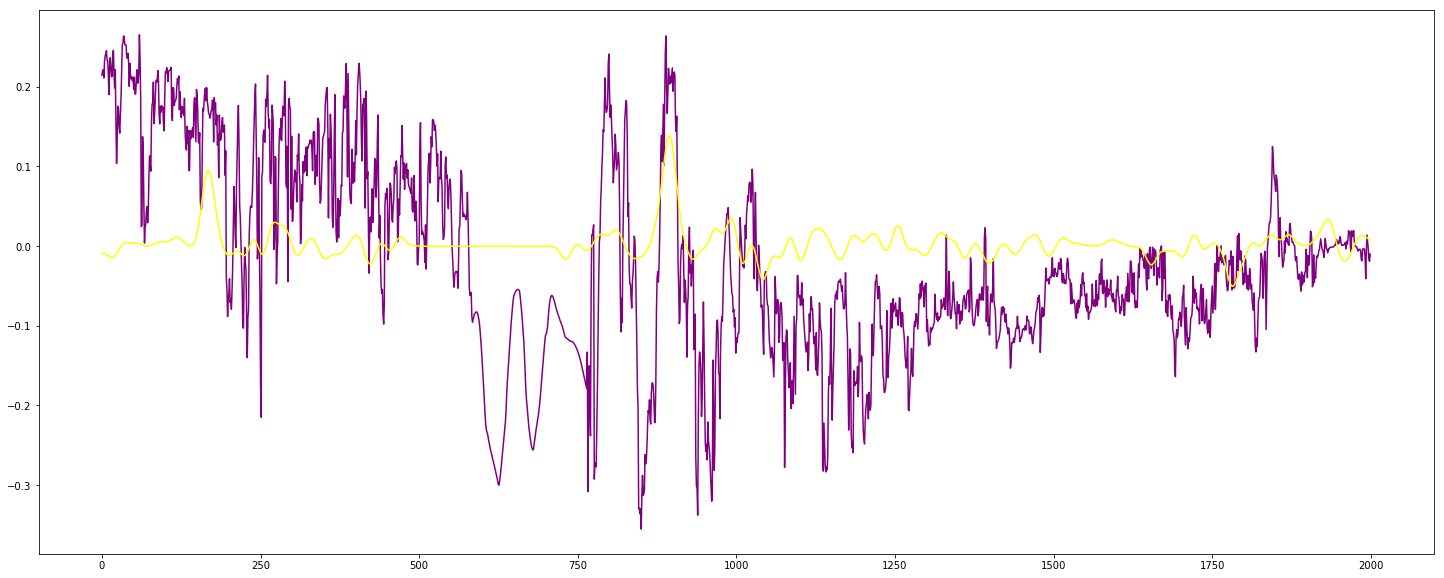

In [10]:
plt.figure(figsize=(25,10))
plt.plot(predicted_BTC_price[:2000], color = 'purple')
#plt.plot(X_test[270:800,0,:-1])
plt.plot(validation_target.values[:2000], color = 'yellow')

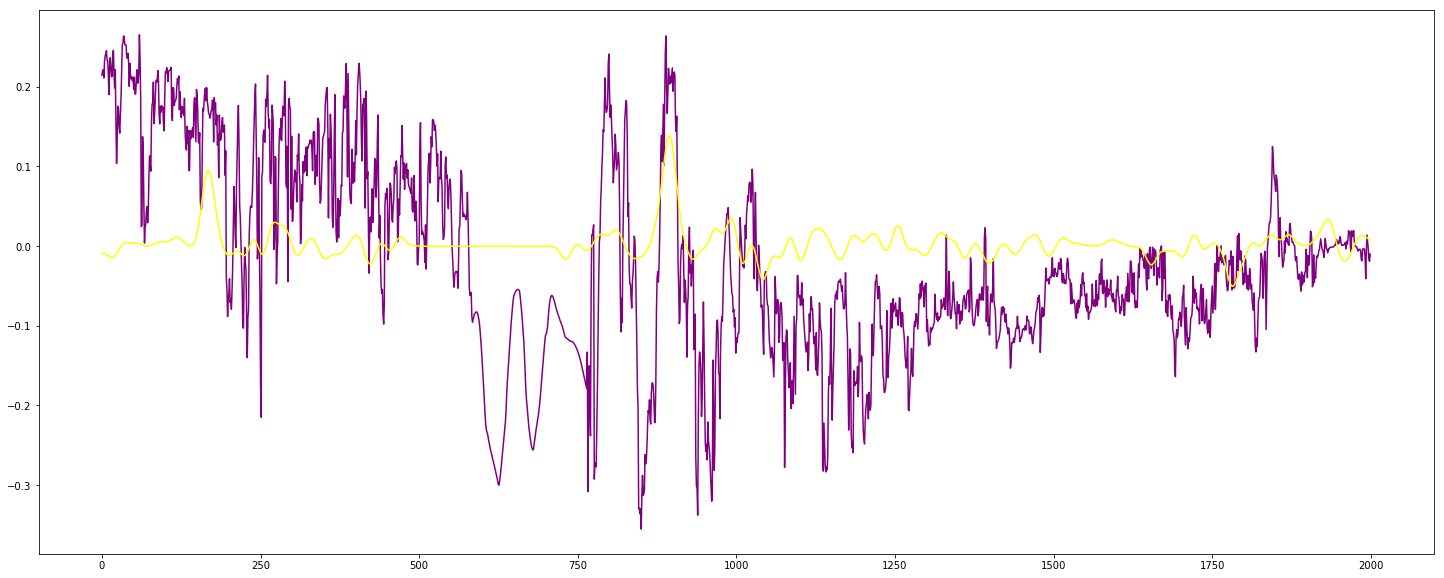

In [9]:
plt.figure(figsize=(25,10))
plt.plot(predicted_BTC_price[:2000], color = 'purple')
plt.plot(X_test[270:800,0,:-1])
plt.plot(validation_target.values[:2000], color = 'yellow')

In [30]:
predicted_BTC_change_60_input = dataset[['Weighted_Price_rolling_5', 'Weighted_Price_rolling_15', 'Weighted_Price_rolling_60', 
                      'Weighted_Price_rolling_180', 'Weighted_Price_rolling_720', 'Weighted_Price_rolling_2880',
                     'Weighted_Price_rolling_10080', 'Volume_PCT_rolling_5', 'Volume_PCT_rolling_15',
                     'Volume_PCT_rolling_60', 'Volume_PCT_rolling_180', 'Volume_PCT_rolling_720', 
                     'Volume_PCT_rolling_2880', 'Volume_PCT_rolling_10080']].iloc[-(OFFSET*10):]

predicted_BTC_change_60_input = np.expand_dims(predicted_BTC_change_60_input, axis=1)

predicted_BTC_change_60 = regressor.predict(predicted_BTC_change_60_input)


price_data = dataset['Weighted_Price'].iloc[-(OFFSET*10):]
#predicted_price_data = price_data * predicted_BTC_change_60

In [35]:
price_data

1458476    5731.529778
1458477    5737.776432
1458478    5737.706601
1458479    5735.422076
1458480    5736.339513
1458481    5736.239491
1458482    5736.238862
1458483    5732.901698
1458484    5725.946560
1458485    5725.947783
1458486    5725.943935
1458487    5725.950000
1458488    5725.950000
1458489    5726.753649
1458490    5730.490000
1458491    5730.488659
1458492    5730.490000
1458493    5730.489871
1458494    5730.490000
1458495    5730.490000
1458496    5730.488536
1458497    5730.490000
1458498    5730.502119
1458499    5731.157319
1458500    5732.984088
1458501    5732.988478
1458502    5732.989893
1458503    5730.053560
1458504    5728.074378
1458505    5725.592923
              ...     
1459046    5710.010000
1459047    5710.010000
1459048    5710.010000
1459049    5710.009257
1459050    5710.018983
1459051    5711.296038
1459052    5711.350008
1459053    5709.731232
1459054    5705.260000
1459055    5705.257835
1459056    5705.251748
1459057    5707.997020
1459058    

In [57]:
out = np.multiply(price_data.values,predicted_BTC_change_60[:,0])
out = price_data.values*(1+predicted_BTC_change_60[:,0]/6)
print(len(predicted_BTC_change_60))

print(len(price_data))

600
600


In [58]:
print(predicted_BTC_change_60[:,0])

[ -5.77753037e-03  -3.10639031e-02  -1.75461918e-03   1.65921822e-02
   1.07168406e-03  -9.97272879e-03  -1.70298666e-03  -3.46111879e-03
  -5.01298532e-03  -1.29378252e-02  -1.96936131e-02  -6.03543222e-03
  -2.36431137e-03  -4.67223674e-03  -4.24260274e-03  -5.81435859e-04
   4.08485532e-03  -9.14838165e-04  -1.68053061e-03  -6.42210245e-04
   7.35044479e-04   2.20709294e-03   1.21193379e-03   1.28485262e-04
   4.78215516e-04   2.52301991e-03   4.37639654e-03   3.84435058e-04
  -3.02159041e-03  -8.58964399e-03  -8.24511424e-03  -9.23962146e-03
  -1.20875239e-02  -1.30246393e-02  -8.33036378e-03   2.43327767e-03
  -1.50381774e-03  -1.76243857e-03  -7.28037208e-04   4.04153764e-03
   1.14565492e-02   9.12674516e-03   6.88736886e-03   6.89148903e-03
   3.69419903e-03   2.12610513e-03   2.81929225e-03   3.32934409e-03
   2.22223252e-03  -4.03605402e-04  -5.18685207e-03  -1.60538331e-02
  -2.17964463e-02  -1.32987797e-02  -9.57316160e-03  -1.72397681e-02
  -2.72068977e-02   3.58200073e-03

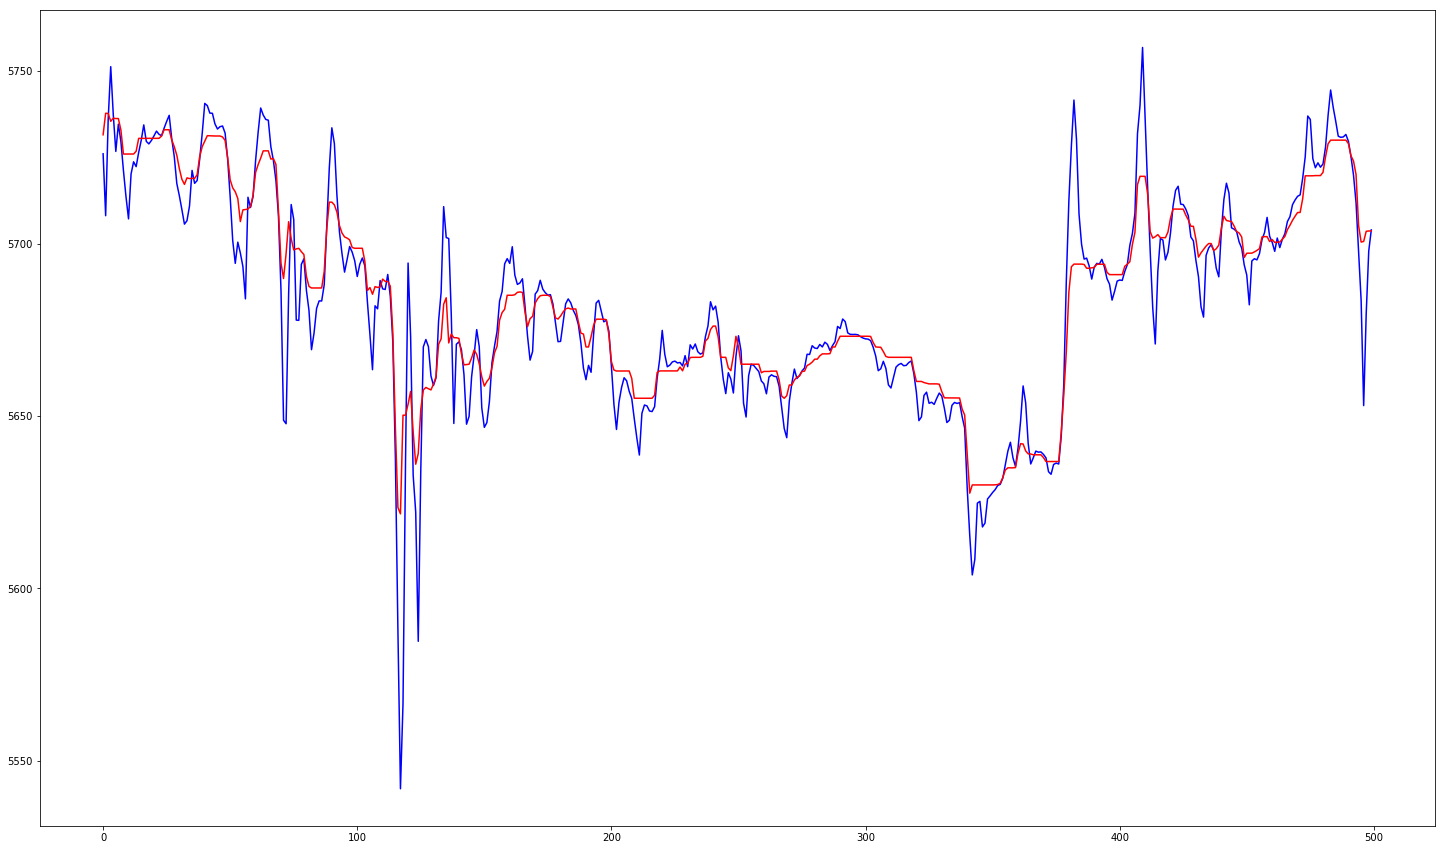

In [60]:
plt.figure(figsize=(25,15))
plt.plot(out[:500], color = 'blue')
plt.plot(price_data.values[:500], color = 'red')

In [ ]:
plt.figure(figsize=(25,15))
plt.plot(dataset['Weighted_Price_PCT_hour'].iloc[-5000:])
plt.plot(dataset['Weighted_Price_PCT'].iloc[-5000:])
#plt.plot(dataset['Volume_(BTC)_PCT'].iloc[-5000:]*0.01)

In [ ]:
low = 98368.004
mid = 26861.522
high = 8936.917

In [17]:
low = 2437
mid = 543.5
high = 189.8

In [18]:
R1 = mid + (mid*(low + high)  - 2*high*low)/(high + low -2*mid)
R1

869.8934277178854

In [19]:
R2 = R1 - mid
R2

326.3934277178854

In [20]:
R3 = R1*(R1 + low - mid)/(low-mid)
R3

1269.5314396464685